# First Notebook

On this Notebook we use ERA5 and the classification of  [@wang2018automated](https://ieeexplore.ieee.org/abstract/document/8518354?casa_token=jyWw34J2BmMAAAAA:bnc6b5hNQiXohTV8JEVxbc_4Dd_GfFAlqstEl0Ks2Xd8I-8c9St8bDiADQAK8jO6rUor0_s7Eg) to select our data.

**Note: This Notebook won't run as we do not have the `/dataframes_w_chen_classes` directory in Github.**

Nonetheless, the end-goal is to write `processed_data/wv1_unstable_gt15.parquet` and `processed_data/wv2_unstable_gt15.parquet`, that we'll use in `second_notebook.ipynb`

In [1]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
from pathlib import Path
from scipy import stats

In [2]:
# get a list with all files inside the folder dataframes_w_chen_classes
 
all_df_files = glob('/projects/fluxsar/data/Sentinel1/dataframes_w_chen_classes/*.parquet')
all_dfs = [pd.read_parquet(f) for f in all_df_files]

In [3]:
# concatenate all dataframes into one
df = pd.concat(all_dfs)
df = df.dropna()
print(df.columns)
print(f"There are {len(df)} observations in the dataframe.")
df.head(5)

Index(['value', 'wm_type', 'lonlat_center', 'tif_path', 'process_status',
       'class_1', 'prob_1', 'class_2', 'prob_2', 'class_3', 'prob_3',
       'all_prob', 'processing_time', 'filename', 'date_time', 'latitude',
       'longitude', 'L', 'wspd', 'wdir', 'sst', 'airt', 'p', 'rh', 'blh',
       'msdwswrf', 'msdwlwrf'],
      dtype='object')
There are 2817276 observations in the dataframe.


,value,wm_type,lonlat_center,tif_path,process_status,class_1,prob_1,class_2,prob_2,class_3,...,L,wspd,wdir,sst,airt,p,rh,blh,msdwswrf,msdwlwrf
0,1,wv1,-168.306107721 50.6175302243,/home/datawork-cersat-public/cache/public/ftp/...,OK,POS,0.995881,OF,0.002468,IB,...,-72.419839,6.158391,1.648738,5.668366,4.754730,1036.3213,78.28288,642.61050,0.0,268.92557
1,2,wv2,-171.133670442 50.0862897567,/home/datawork-cersat-public/cache/public/ftp/...,OK,OF,0.718723,POS,0.124873,AF,...,-191.378425,8.351667,0.676627,5.781647,5.028168,1035.7887,79.07464,534.73550,0.0,295.24588
2,3,wv1,-168.892954812 48.8677389335,/home/datawork-cersat-public/cache/public/ftp/...,OK,LWA,0.950605,AF,0.032355,BS,...,-20.285698,4.298893,1.567847,6.680084,5.155121,1037.4137,77.11538,497.23547,0.0,241.94120
3,4,wv2,-171.618914782 48.3322469348,/home/datawork-cersat-public/cache/public/ftp/...,OK,WS,0.635871,OF,0.171662,MCC,...,-50.899151,6.170361,0.607764,6.940826,5.657074,1037.6837,74.74324,558.48550,0.0,289.20682
4,5,wv1,-169.444607427 47.1151315664,/home/datawork-cersat-public/cache/public/ftp/...,OK,OF,0.681065,AF,0.121722,POS,...,-1.537463,1.157664,-2.731204,7.980866,5.879730,1037.9463,67.62807,384.36047,0.0,255.28494


In [4]:
def plot_class_and_prob(all_dfs):
    """
    Merge all DataFrames and plot:
    1) class_1 frequency
    2) class_2 frequency
    3) class_3 frequency
    4) boxplot of prob_1, prob_2, prob_3
    5) boxplot of prob_1 grouped by class_1
    """
    combined_df = pd.concat(all_dfs, ignore_index=True)
    plt.style.use('ggplot')
    fig, axes = plt.subplots(1, 3, figsize=(20, 4))
    
    class1_counts = combined_df['class_1'].value_counts()
    axes[0].bar(class1_counts.index, class1_counts.values)
    axes[0].set_title('Class 1 Frequency')
    
    prob_data = [
        combined_df['prob_1'].dropna(),
        combined_df['prob_2'].dropna(),
        combined_df['prob_3'].dropna()
    ]
    axes[1].boxplot(prob_data, tick_labels=['Prob 1', 'Prob 2', 'Prob 3'])
    axes[1].set_title('Probability Distribution')
    
    class1_groups = combined_df.groupby('class_1')['prob_1']
    prob_by_class1 = [group for _, group in class1_groups]
    axes[2].boxplot(prob_by_class1, tick_labels=class1_groups.groups.keys())
    axes[2].set_title('Prob_1 by Class_1')
    
    plt.tight_layout()
    plt.show()


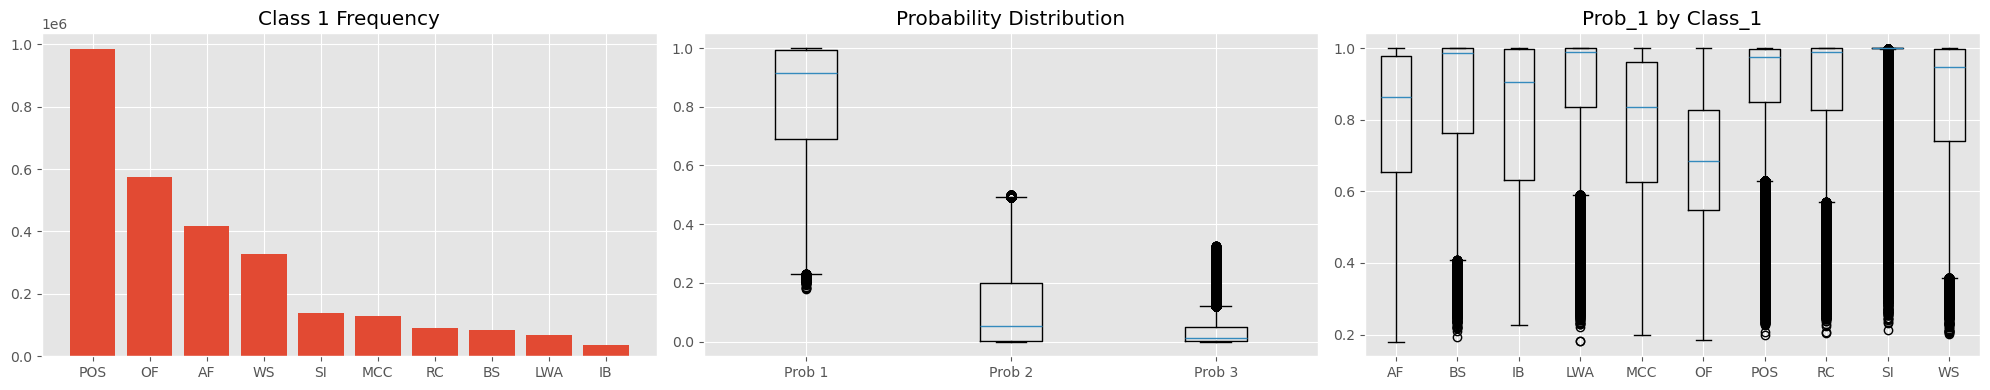

In [5]:
plot_class_and_prob(all_dfs)

Each image is classified as `wm1` or `wm2` (23 and 36 deg incidence angle, respectively) and have one of the 10 classes according to [@wang2018automated](https://ieeexplore.ieee.org/abstract/document/8518354?casa_token=jyWw34J2BmMAAAAA:bnc6b5hNQiXohTV8JEVxbc_4Dd_GfFAlqstEl0Ks2Xd8I-8c9St8bDiADQAK8jO6rUor0_s7Eg), below for easy reference:

_"We have identified 10 types of phenomena commonly observed in WV data: pure ocean swell (POS), wind treaks (WS), micro convective cells (MCC), rain cells (RC), iological slicks (BS), sea ice (SI), icebergs (IB), low wind area (LWA), atmospheric fronts (AF), oceanic fronts (OF). Vignettes that do not clearly fall into one of these categories are given a label unknown (UKN)"_

<center>

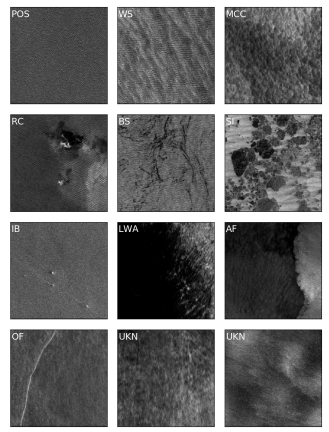

</center>

The goal is to check if incidence angle changes the relationship between NRCS and surface wind/stress variability as **different incidence angles emphasize different scattering scales**. Therefore, if the statistics differ significantly between `wv1` and `wv2`, it suggests that the scale-dependent variations are not uniform.

The goal is to quantify this by comparing moment-based metrics (mean, variance) or performing hypothesis tests on each incidence-angle subset. If there’s a consistent difference, it supports the idea that the wind-stress field is indeed scale-dependent and that GMFs must account for incidence angle when capturing that variability.

According to [@de2019validation](https://wes.copernicus.org/articles/5/1023/2020/), low wind speed and neutral/stable atmospheric conditions introduce uncertainties. Therefore, **high wind speeds and unstable conditions should be the best regime to test for scale-dependent variability** in the wind stress.

Below is the code to get the data we want. (L<0 and wspd>15 kts).

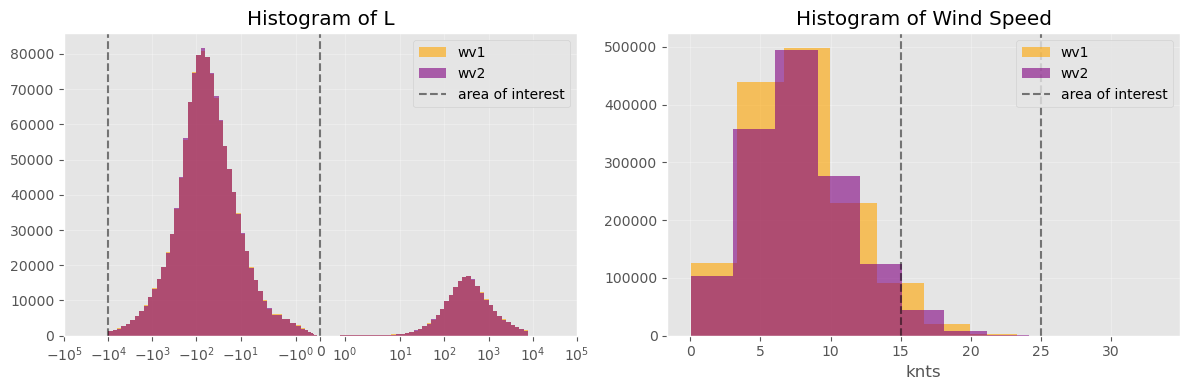

In [6]:
# split into wv1 and wv2

wv1_df = df[df.wm_type == 'wv1']
wv2_df = df[df.wm_type == 'wv2']


def plot_wv_histograms(wv1_df, wv2_df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    delta = 0.1
    bins = np.concatenate((-10**np.arange(4, -4, -delta), 10**np.arange(-4, 4, delta)))
    
    ax1.hist(wv1_df.L, bins=bins, alpha=0.6, label='wv1', color='orange')
    ax1.hist(wv2_df.L, bins=bins, alpha=0.6, label='wv2', color='purple')
    ax1.axvline(0, color='black', linestyle='--', alpha=0.5, label='area of interest')
    ax1.axvline(-10**4, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlim(-10**5, 10**5)
    ax1.set_xscale('symlog')
    ax1.set_title('Histogram of L')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    ax2.hist(wv1_df.wspd, alpha=0.6, color='orange', label='wv1')
    ax2.hist(wv2_df.wspd, alpha=0.6, color='purple', label='wv2')
    ax2.axvline(15, color='black', linestyle='--', alpha=0.5, label='area of interest')
    ax2.axvline(25, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('knts')
    ax2.set_title('Histogram of Wind Speed')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_wv_histograms(wv1_df, wv2_df)

In [7]:
def create_filtered_dfs(df, name_prefix):
    filtered_dfs = {}
    
    wspd_ranges = [
        (0, 15),
        (15, float('inf')),
    ]
    
    stability_conditions = [
        ('unstable', lambda x: x < 0),
        ('stable', lambda x: x > 0)
    ]
    
    for stability_name, stability_condition in stability_conditions:
        for i, (min_wspd, max_wspd) in enumerate(wspd_ranges):
            if max_wspd == float('inf'):
                range_desc = f'gt15'
            else:
                range_desc = f'lt15'
            
            filtered_df = df[
                (stability_condition(df.L)) & 
                (df.wspd > min_wspd) & 
                (df.wspd <= max_wspd if max_wspd != float('inf') else df.wspd > min_wspd)
            ]
            
            df_name = f'{name_prefix}_{stability_name}_{range_desc}'
            filtered_dfs[df_name] = filtered_df
    
    return filtered_dfs

wv1_filtered = create_filtered_dfs(wv1_df, 'wv1')
wv2_filtered = create_filtered_dfs(wv2_df, 'wv2')

all_filtered_dfs = {**wv1_filtered, **wv2_filtered}

for df_name, filtered_df in all_filtered_dfs.items():
    print(f"{df_name}: {len(filtered_df)} rows")

wv1_unstable_gt15 = all_filtered_dfs['wv1_unstable_gt15'].copy()
wv2_unstable_gt15 = all_filtered_dfs['wv2_unstable_gt15'].copy()

wv1_unstable_lt15: 1156562 rows
wv1_unstable_gt15: 36925 rows
wv1_stable_lt15: 195435 rows
wv1_stable_gt15: 19136 rows
wv2_unstable_lt15: 1158320 rows
wv2_unstable_gt15: 37000 rows
wv2_stable_lt15: 194475 rows
wv2_stable_gt15: 19423 rows


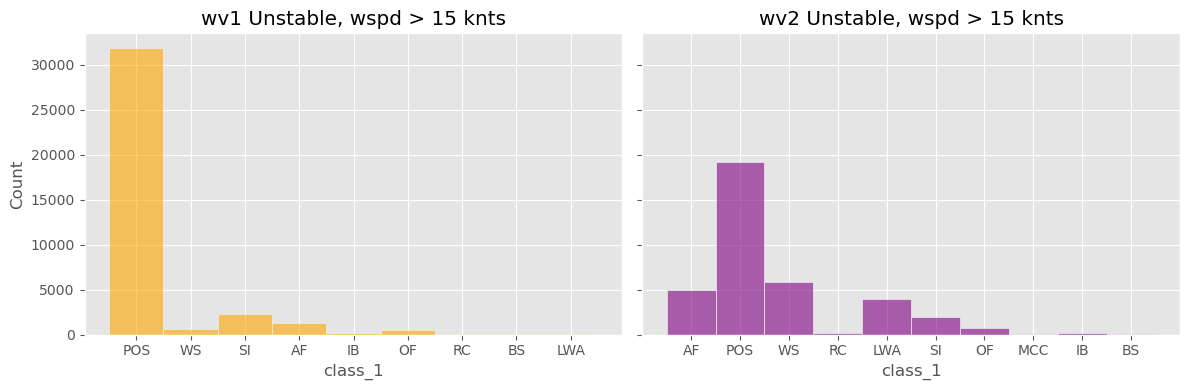

In [8]:
# check the class distribution of the chosen regime

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.histplot(wv1_unstable_gt15.class_1, bins=20, color='orange', alpha=0.6, ax=axes[0])
axes[0].set_title('wv1 Unstable, wspd > 15 knts')
sns.histplot(wv2_unstable_gt15.class_1, bins=20, color='purple', alpha=0.6, ax=axes[1])
axes[1].set_title('wv2 Unstable, wspd > 15 knts')
plt.tight_layout()


In [9]:
SARDATA_PATH = Path("/projects/fluxsar/data/Sentinel1/WV/")
SARDATA_PATH_2020 = SARDATA_PATH / "2020"
SARDATA_PATH_2021 = SARDATA_PATH / "2021"

In [10]:
# rename the filenames so it matches the SAR data
def rename_filename(f):
    f = f.split("/")[-1]
    flist = f.split(".SAFE:")
    f = flist[0] + "__" + flist[1] + ".nc"
    return f 

# Function to check if file exists in either 2020 or 2021 folder
def check_file_exists(filename):
    path_2020 = SARDATA_PATH_2020 / filename
    path_2021 = SARDATA_PATH_2021 / filename
    
    if path_2020.exists():
        return True, path_2020
    elif path_2021.exists():
        return True, path_2021
    else:
        return False, None

# Apply renaming
wv1_unstable_gt15.loc[:, 'renamed_filename'] = wv1_unstable_gt15.loc[:, 'filename'].apply(rename_filename)
wv2_unstable_gt15.loc[:, 'renamed_filename'] = wv2_unstable_gt15.loc[:, 'filename'].apply(rename_filename)

# Check existence and get paths
wv1_results = [check_file_exists(filename) for filename in wv1_unstable_gt15['renamed_filename']]
wv2_results = [check_file_exists(filename) for filename in wv2_unstable_gt15['renamed_filename']]

# Extract results
wv1_unstable_gt15.loc[:, 'exists_ok'] = [result[0] for result in wv1_results]
wv1_unstable_gt15.loc[:, 'path_to_sar_file'] = [result[1] for result in wv1_results]

wv2_unstable_gt15.loc[:, 'exists_ok'] = [result[0] for result in wv2_results]
wv2_unstable_gt15.loc[:, 'path_to_sar_file'] = [result[1] for result in wv2_results]

# Drop NaNs if needed
wv1_unstable_gt15.dropna(inplace=True)
wv2_unstable_gt15.dropna(inplace=True)

print(f"We have {len(wv1_unstable_gt15)} wv1 obs and {len(wv2_unstable_gt15)} wv2 obs.")

We have 36925 wv1 obs and 37000 wv2 obs.


# Looking at SAR WV mode data

Below is what statistics we are going to compute.

## Spectral Analysis of SAR Imagery

1. **Sigma0 Statistics** (Spatial Domain):
   ```python
   mean_sigma0 = np.mean(sigma0_values)        # Average backscatter
   var_sigma0 = np.var(sigma0_values)          # Variance
   skewness_sigma0 = stats.skew(sigma0_values.flatten())
   kurtosis_sigma0 = stats.kurtosis(sigma0_values.flatten())
   ```

2. **Power Spectral Density (PSD) Computation**:
   ```python
   fft_data = np.fft.fft2(sigma0_values)  # 2D Fast Fourier Transform
   psd_2d = np.abs(fft_data)**2           # PSD = |FFT|²
   ```

3. **Frequency Band Division**:
   - **Band0** (0 ≤ k < 0.1): Large-scale features → `mean_psd_band0`
   - **Band1** (0.1 ≤ k < 0.3): Medium-scale features → `mean_psd_band1`
   - **Band2** (0.3 ≤ k < ∞): Small-scale features → `mean_psd_band2`

4. **Statistics per Band**:
   - Mean power
   - Variance
   - Skewness
   - Kurtosis

In [11]:
def compute_spectral_statistics(sigma0_values):
    """
    Compute scalar statistics from both spatial and spectral domains.
    Returns only scalar values suitable for large-scale analysis.

    Parameters:
    -----------
    sigma0_values : np.ndarray
        2D array of sigma0 values

    Returns:
    --------
    dict
        Dictionary containing only scalar statistical values
    """
    # Ensure we're working with a 2D array
    if sigma0_values.ndim == 3:
        sigma0_values = sigma0_values[0]  # Take first slice if 3D

    if np.isnan(sigma0_values[-1, :]).all():
        sigma0_values = sigma0_values[:-1, :]  # Remove last row if all NaNs

    if np.isnan(sigma0_values[:, -1]).all():
        sigma0_values = sigma0_values[:, :-1] # Remove last column if all NaNs
    
    try:
        # 1. Spatial domain statistics
        stats_dict = {
            'mean_sigma0': np.mean(sigma0_values),
            'var_sigma0': np.var(sigma0_values),
            'skewness_sigma0': stats.skew(sigma0_values.flatten()),
            'kurtosis_sigma0': stats.kurtosis(sigma0_values.flatten())
        }

        # 2. Compute 2D power spectrum
        fft_data = np.fft.fft2(sigma0_values)
        psd_2d = np.abs(fft_data)**2

        # 3. Statistics of the full 2D spectrum
        stats_dict.update({
            'mean_psd2d': np.mean(psd_2d),
            'var_psd2d': np.var(psd_2d),
            'skewness_psd2d': stats.skew(psd_2d.flatten()),
            'kurtosis_psd2d': stats.kurtosis(psd_2d.flatten())
        })

        # 4. Compute azimuthal average and its statistics
        freq_x = np.fft.fftfreq(sigma0_values.shape[1])  # Use shape[1] for columns
        freq_y = np.fft.fftfreq(sigma0_values.shape[0])  # Use shape[0] for rows
        kx, ky = np.meshgrid(freq_x, freq_y)
        k_magnitude = np.sqrt(kx**2 + ky**2)  # Fixed the power calculation

        # Define wavenumber bands (you might want to adjust these)
        k_bands = [
            (0, 0.1),     # Low wavenumbers (large scales)
            (0.1, 0.3),   # Medium wavenumbers
            (0.3, np.inf) # High wavenumbers (small scales)
        ]

        # Compute statistics for each wavenumber band
        for i, (k_min, k_max) in enumerate(k_bands):
            mask = (k_magnitude >= k_min) & (k_magnitude < k_max)
            if np.any(mask):
                band_data = psd_2d[mask]
                band_name = f'band{i}'
                stats_dict.update({
                    f'mean_psd_{band_name}': np.mean(band_data),
                    f'var_psd_{band_name}': np.var(band_data),
                    f'skewness_psd_{band_name}': stats.skew(band_data),
                    f'kurtosis_psd_{band_name}': stats.kurtosis(band_data)
                })

        return stats_dict

    except Exception as e:
        print(f"Error computing spectral statistics: {str(e)}")
        return None

def process_dataset(file_path):
    """
    Process a single dataset file and return scalar statistics
    """
    try:
        with xr.open_dataset(file_path) as ds:
            sigma0_values = ds.sigma0.values  # Don't index here
            return compute_spectral_statistics(sigma0_values)
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        return None

wv1_unstable_gt15['spectral_stats'] = wv1_unstable_gt15['path_to_sar_file'].apply(process_dataset)
# Then expand the dictionary columns:
for stat_name in wv1_unstable_gt15.spectral_stats.iloc[0].keys():
    wv1_unstable_gt15[stat_name] = wv1_unstable_gt15.spectral_stats.apply(
        lambda x: x.get(stat_name) if x else None
    )

wv2_unstable_gt15['spectral_stats'] = wv2_unstable_gt15['path_to_sar_file'].apply(process_dataset)
# Then expand the dictionary columns:
for stat_name in wv2_unstable_gt15.spectral_stats.iloc[0].keys():
    wv2_unstable_gt15[stat_name] = wv2_unstable_gt15.spectral_stats.apply(
        lambda x: x.get(stat_name) if x else None
    )

Error processing /projects/fluxsar/data/Sentinel1/WV/2020/S1A_WV_SLC__1SSV_20200508T055149_20200508T060616_032469_03C29E_0173__WV_035.nc: [Errno -101] NetCDF: HDF error: '/projects/fluxsar/data/Sentinel1/WV/2020/S1A_WV_SLC__1SSV_20200508T055149_20200508T060616_032469_03C29E_0173__WV_035.nc'
Error processing /projects/fluxsar/data/Sentinel1/WV/2020/S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_015.nc: [Errno -101] NetCDF: HDF error: '/projects/fluxsar/data/Sentinel1/WV/2020/S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_015.nc'
Error processing /projects/fluxsar/data/Sentinel1/WV/2020/S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_029.nc: [Errno -101] NetCDF: HDF error: '/projects/fluxsar/data/Sentinel1/WV/2020/S1A_WV_SLC__1SSV_20200508T041601_20200508T043747_032468_03C294_9766__WV_029.nc'
Error processing /projects/fluxsar/data/Sentinel1/WV/2020/S1A_WV_SLC__1SSV_20200508T035531_20200508T040337_032468_03C292_D74

In [13]:
# write both wv1_unstable_gt15 and wv2_unstable_gt15 to parquet files

wv1_unstable_gt15.path_to_sar_file = wv1_unstable_gt15.path_to_sar_file.apply(lambda x: str(x))
wv2_unstable_gt15.path_to_sar_file = wv2_unstable_gt15.path_to_sar_file.apply(lambda x: str(x))

wv1_unstable_gt15.to_parquet('processed_data/wv1_unstable_gt15.parquet')
wv2_unstable_gt15.to_parquet('processed_data/wv2_unstable_gt15.parquet')